<a href="https://colab.research.google.com/github/ds-kenwatanabe/google_colab_projects/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Pytorch paper replicating - Milestone Project 2
The goal of machine learning research paper replicating is:
to turn ML research paper into usable code.

In this notebook we are going to be replicating the vision transformer (ViT) paper.

Abstract link: https://arxiv.org/abs/2010.11929v2

## 0. Setting up
First import code previously written and required libraries

In [ ]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Mon Aug  7 15:51:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |   7583MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data
The whole goal is to replicate ViT architecture for our FoodVision Mini problem.
To do that, we need data.
Namely, the pizza, steak, sushi images we have been using so far.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Set up directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Creting DataLoaders and Datasets
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size
IMG_SIZE = 224  # Table 3 of the ViT paper

# Create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print(f"Manually create transforms: {manual_transforms}")

Manually create transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096, but this might be too big for
# the smaller hardwares. It is possible to scale up later).

BATCH_SIZE = 32

# Create Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image
Visualize, visualize, visualize...

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Visualize a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

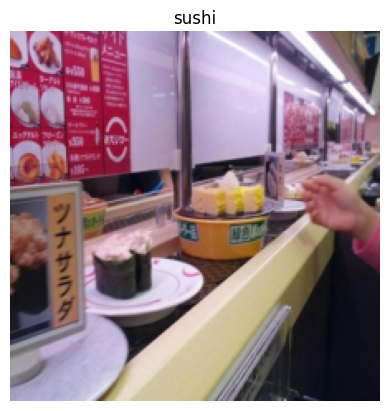

In [ ]:
# Plot the image
plt.imshow(image.permute(1, 2, 0))  # (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)
plt.show()

## 3. Replicating ViT: Overview
In order to make the research paper more understandable, we can break it down into smaller pices.

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/laye/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example, self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1 and 3: different hyperparameters for each architecture/training
* Text

### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = learnable representation (start with random numbers and improve over time)

### Four equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)


#### Section 3.1 describes the four equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

**Note: added text ->**
In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_n] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_n_pos]
```

**Equation 2 & 3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right.$ ), whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* Note:
* MLP = Multilayer Perceptron = a neural network with x number of layers
* MLP = One hidden layer at trainig time
* MLP = single linear layer at fine tuning time

In psudocode
```python
# Equation 4
y = MLP_or_Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

* Note:
* Vit-Base, Large and Huge are all different sizes of the same model architecture
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embeding size throughout the architecture
* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and create the class, position, and patch embedding

Layers = input -> function -> output

What is the input shape?
What is the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color_channels)
* Output shape: ??

### 4.1 Calculated input and output shapes by hand

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input image: ${H}\times{W}\times{C}$ (height, width, color_channels)
* Output image: ${N \times\left(P^2 \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.1 Turning single image into patches

Let's visualize!

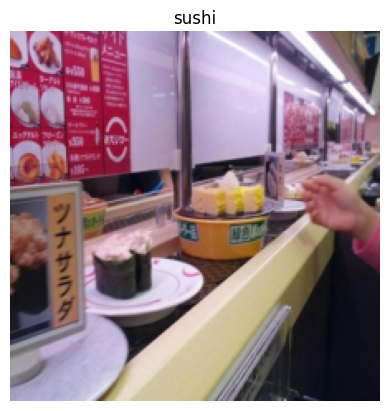

In [ ]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [ ]:
image.shape

torch.Size([3, 224, 224])

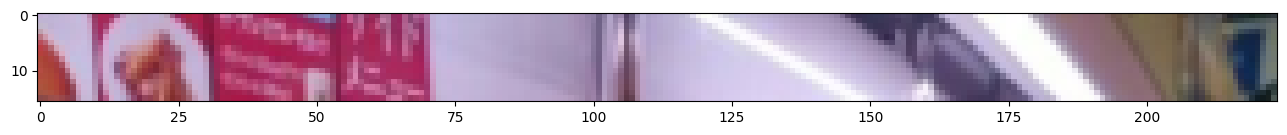

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot th etop row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.show()

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


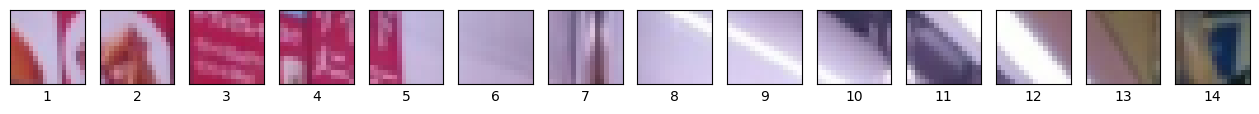

In [ ]:
# Set up code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} \
pixels x {patch_size} pixels")

# Create a series of subplpots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,  # one column per patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iter through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)  # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixel x 16 pixels


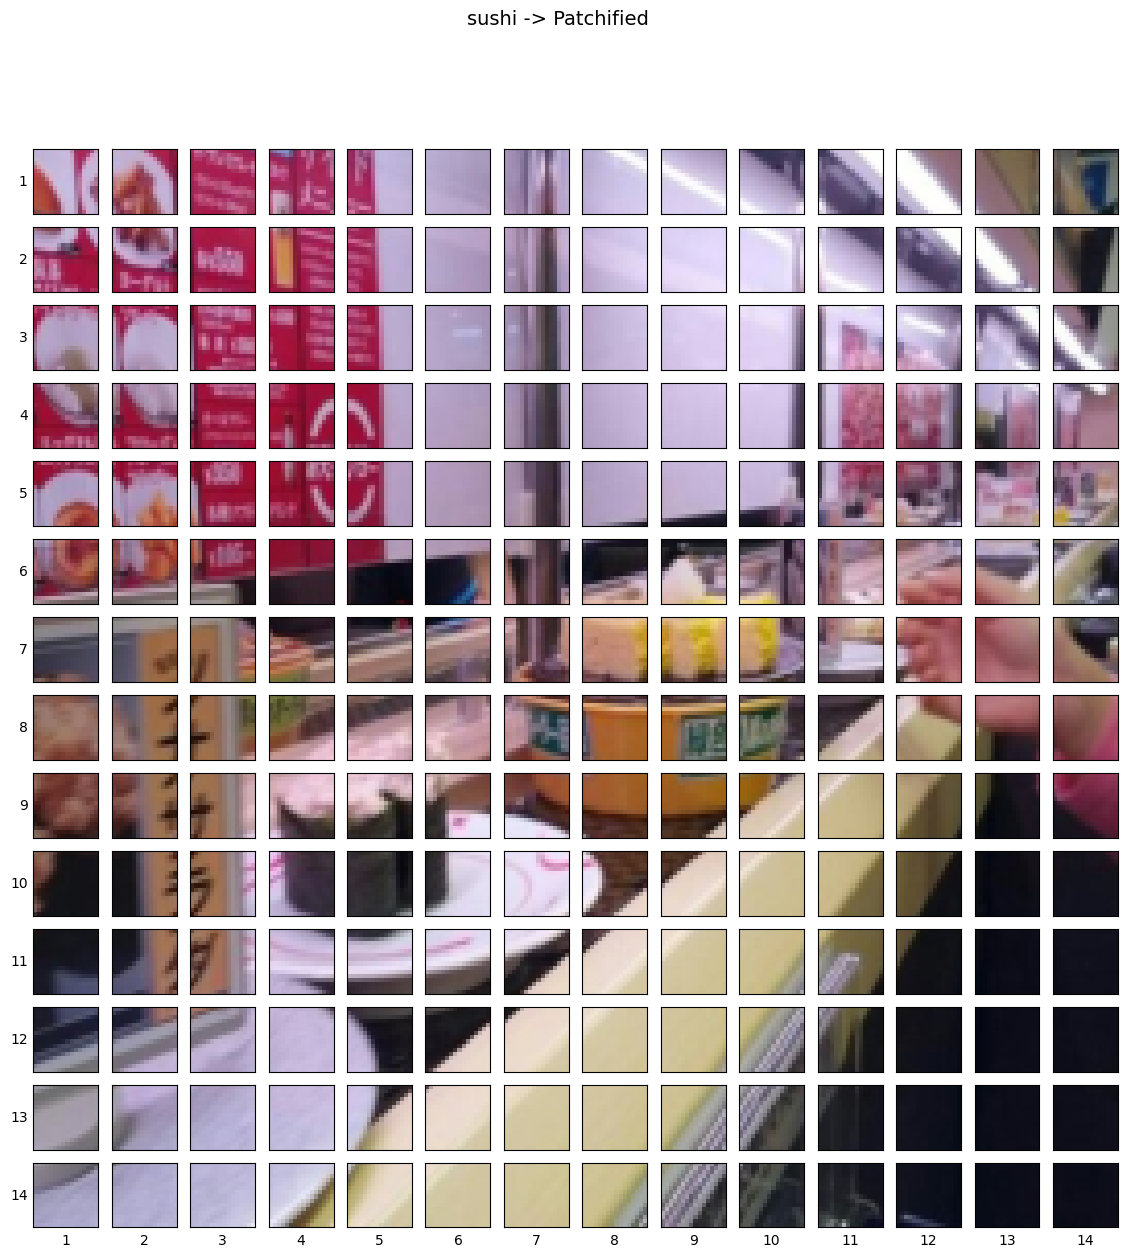

In [ ]:
# Set up code to plot image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches * num_patches}\
\nPatch size: {patch_size} pixel x {patch_size} pixels")

# Create a series of subplots
fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True)

# Loop through height and width of the image
# iterate through height
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                          patch_width:patch_width+patch_size, :])
        # iterate through height, width and color channels
        # Set up label information for each subplot
        axis[i, j].set_ylabel(i+1,
                              rotation="horizontal",
                              horizontalalignment="right",
                              verticalalignment="center")
        axis[i, j].set_xlabel(j+1)
        axis[i, j].set_xticks([])
        axis[i, j].set_yticks([])
        axis[i, j].label_outer()
    # Set a title for the plot
    fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.2 Creating image patches and turning the into patch embeddings

We could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to
`patch_size`.

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps
# (embeddings)

# set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from thw ViT paper
# in=3, color channels, out=768, D (embedding) size from Image 1
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

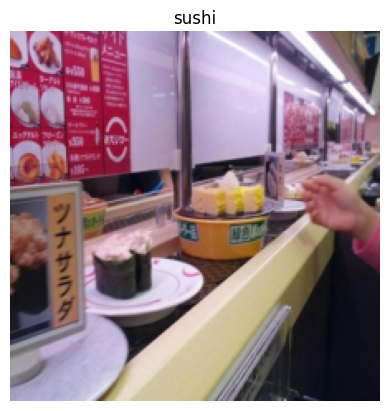

In [ ]:
# Visualize a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension -> (batch_size, color_channels_height_width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
14 * 14

196

Now we have passed a single image to our `conv2d` layer, the shape is:

```python
torch.Size([1, 768, 14, 14])  # [batch_size, embedding_dim, feature_map_height,feature_map_width]
```

Showing random convolutional feature maps from indexes: [208, 177, 55, 694, 139]


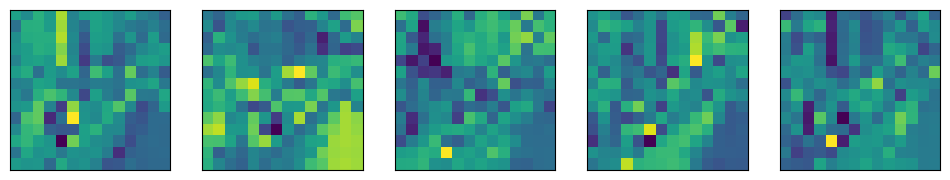

In [ ]:
# Plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    # index on the output tensor of the conv2d layer
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    # remove batch dimension, and remove grad tracking/switch to numpy
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.7528, -0.7226, -0.6959, -0.5794, -0.7675, -0.7844, -0.6366,
           -1.0255, -0.8601, -0.3476, -0.7706, -0.7686, -0.4508, -0.5337],
          [-0.7739, -0.4228, -0.5214, -0.7456, -0.7439, -0.8148, -0.6213,
           -0.9849, -1.0425, -1.0382, -0.5894, -0.7540, -0.5610, -0.2563],
          [-0.7318, -0.6252, -0.8052, -0.6059, -0.7398, -0.7504, -0.4864,
           -0.9255, -1.0313, -0.9164, -1.1732, -0.8121, -0.7085, -0.5582],
          [-0.6771, -0.7440, -0.6500, -0.5437, -0.7248, -0.7905, -0.4338,
           -0.9062, -0.9685, -0.7890, -0.8474, -0.7093, -0.9484, -0.7828],
          [-0.5555, -0.5757, -0.7249, -0.6330, -0.6808, -0.7754, -0.4054,
           -0.8834, -0.8546, -0.7135, -0.7371, -0.4553, -0.5307, -0.7294],
          [-0.5667, -0.6252, -0.4702, -0.3151, -0.4454, -0.8593, -0.2582,
           -0.3863, -0.3417, -0.3548, -0.6911, -0.7226, -1.0398, -0.4889],
          [-0.5581, -0.6291, -0.7292, -0.1800, -0.3828, -0.5905, -0.4223,
           -0.8815, -0.8491, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we have a series of convolutional feature maps (patch embeddings) that need to be flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [ ]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Right now we have patch_size, embedding_dim, and number of patches

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


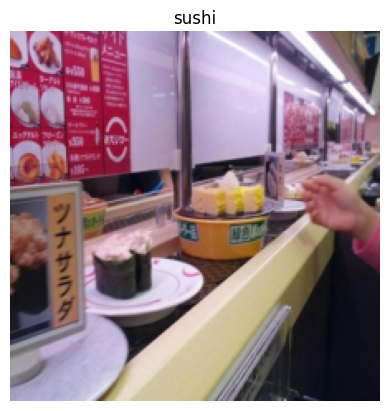

In [ ]:
# Putting everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn the image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


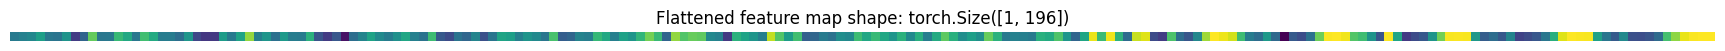

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
# single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()

### 4.5 Turning the ViT patch embedding layer into a PyTorch module
We want this module to:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g., pass through layer from 4 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embeddings.

In [ ]:
# 1. Create a class called PatchEmbedding


class PatchEmbedding(nn.Module):
    # 2. initialize the layer with appropriate hyperparameters
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):  # from Table 1 for ViT base
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten feature map outputs of Conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    # 5. Define a forward method -> forward computation steps
    def forward(self, x):
        # Create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the returned sequence embeddings are in the right order
        # (batch_size, number_of_patches, embedding_dimensions)
        return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # add extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding
Prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
         [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
         [-0.5068,  0.0556,  0.0090,  ...,  0.2942, -0.2129,  0.1758],
         ...,
         [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
         [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
         [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same
# size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)  # num_of_patches dim

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")
print("(batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
         [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
         ...,
         [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
         [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
         [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])
(batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Create a series of of 1D learnable position embeddings and add them to the sequence of patch embeddings.

In [ ]:
# View the sequence of patch embeddings with the prepended class embeddings
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
          [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
          ...,
          [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
          [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
          [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size ** 2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3065, 1.2171, 0.9304,  ..., 1.3383, 0.5636, 1.2271],
         [0.3639, 0.9388, 0.9192,  ..., 1.5279, 0.6759, 0.9807],
         ...,
         [0.9448, 1.0259, 0.8908,  ..., 1.0866, 0.9571, 1.0328],
         [0.9217, 1.0082, 0.9512,  ..., 1.0639, 0.9767, 1.0148],
         [0.9223, 1.0113, 0.9521,  ..., 1.0549, 0.9712, 1.0216]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding
Code to turn an image in a flattened sequence of patch embeddings was previously written.

Let's see it all in one cell

In [ ]:
# Set the seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape
# class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
#                            requires_grad=True)  # Make sure it's learnable

print(f"Class token embedding shape: {class_token.shape}")

# 7.Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
# position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
#                                   requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead self-attention (MSA block)

* Multihead self-attention: which part of the sequence should pay the most attention to itself.
* In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
* Our neural network (ViT) needs to learn this relatioship/representation.
* To replicate MSA in PyTorch, we ca use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
    * Normalization = makes everything have the same mean and SD.
    * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimensions, here, the $D$ dimension is the embedding dimension.
    * We have to normalize along the embedding dimension, akin to making all the stairs in a staircase all the same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multihead self-attention block (MSA block)."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        # embedding_dim = Hidden size D from Table 1
        # num_heads = Heads from Table 1 for ViT-Base
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        # Is the batch first? (batch, seq, feature)
        # or (batch, num_patches, embedding_dim)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        # PyTorch outputs attn_output_weights, which we do not need
        return attn_output

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through our MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding, patched_image_through_msa_block

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
          [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
          ...,
          [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
          [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
          [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
        grad_fn=<CatBackward0>),
 tensor([[[-0.2546, -0.2028,  0.0917,  ..., -0.4872,  0.9056, -0.5157],
          [-0.2624, -0.1974,  0.0983,  ..., -0.4812,  0.9185, -0.5232],
          [-0.2643, -0.1982,  0.0973,  ..., -0.4785,  0.9188, -0.5256],
          ...,
          [-0.2597, -0.1825,  0.1125,  ..., -0.4780,  0.9121, -0.5214],
          [-0.2647, -0.1968,  0.1033,  ..., -0.4756,  0.9152, -0.5241],
          [-0.2646, -0.1970,  0.1025,  ..., -0.4756,  0.9149, -0.5235]]],
        grad_fn=<TransposeBackward0>))

## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = contains two layer with the GELU non-linearity (section 3.1)
    * MLP is a quite broad term for a block with a series of layers, layer can be multiple or even one hidden layer.
    * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they are often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
    * GELU in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html

* **Dropout** = when used, is applied after every dense (linear) layer, except for the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
* Value for droput available in Table 3

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))
        # same as above

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MSA block: {patched_image_through_msa_block.shape}")
print(f"Output of the MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output of the MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block, patched_image_through_mlp_block

(tensor([[[-0.2546, -0.2028,  0.0917,  ..., -0.4872,  0.9056, -0.5157],
          [-0.2624, -0.1974,  0.0983,  ..., -0.4812,  0.9185, -0.5232],
          [-0.2643, -0.1982,  0.0973,  ..., -0.4785,  0.9188, -0.5256],
          ...,
          [-0.2597, -0.1825,  0.1125,  ..., -0.4780,  0.9121, -0.5214],
          [-0.2647, -0.1968,  0.1033,  ..., -0.4756,  0.9152, -0.5241],
          [-0.2646, -0.1970,  0.1025,  ..., -0.4756,  0.9149, -0.5235]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[-0.0682,  0.0087,  0.0960,  ...,  0.0000, -0.1488,  0.1563],
          [-0.1122, -0.1112,  0.1980,  ..., -0.0988, -0.1280,  0.1949],
          [-0.0402, -0.0420,  0.2091,  ..., -0.0000, -0.1936,  0.1836],
          ...,
          [-0.2211,  0.0006,  0.1930,  ...,  0.1378, -0.1956,  0.2656],
          [-0.1686,  0.0560,  0.0000,  ...,  0.0739, -0.1749,  0.0752],
          [-0.0895, -0.0189,  0.1511,  ..., -0.0846, -0.1679,  0.1732]]],
        grad_fn=<MulBackward0>))

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

* Encoder = turn a sequence into learnable representation.
* Decoder = go from learn representation back to some sort of sequence.
* Residual connections = add a layer input to its subsequent output, this enables the creation of deeper netwroks (prevents weights from getting too small).

In pseudocode:
 ```python
 # Transformer Encoder
 x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
 ```

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1,
                 attn_dropout:int=0):
        super().__init__()

        # Create the MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x  # residual/skip connection for eq 2
        x = self.mlp_block(x) + x  # residual/skip connection for eq 3
        return x

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.3 Create a Transformer Encoder layer with in-built PyTorch layers
Transformer Encoder was created by hand, but PyTorch has ready to use Transformer Encoders layers: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

In [ ]:
# Create the same as above using torch.nnTransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating transformer encoder?
FOR PRACTICE

WE now know how things are implemented and modify them if necessary.

What are the benefits of using a pre-built PyTorch layer?
* Less prone to errors (goes through a bunch of testing).
* Potential performace boost.

### 8.1 All together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
set_seeds()

# Create a random image tensor with same shape as single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [ ]:
# Get a summary using torchinfo.summary
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224),  # batch_size, color_channels, height, width
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT
See how the replicated ViT architecture replicates with the FoodVision Mini data

### 9.1 Creating an optimizer
The paper states that it uses the Adam optimizer (section 4 Training and fine Tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function
The ViT paper does not mention the loss function/criterion used.

Since the problem involes multi-class classification, `torch.nn.CrossEntropyLoss()` is used.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT model

In [ ]:
from going_modular.going_modular import engine

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6697 | train_acc: 0.3086 | test_loss: 1.2545 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3203 | test_loss: 1.0593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3925 | train_acc: 0.4219 | test_loss: 1.3158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2488 | train_acc: 0.4219 | test_loss: 2.3024 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5335 | train_acc: 0.2852 | test_loss: 1.9660 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5853 | train_acc: 0.3164 | test_loss: 1.2593 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3238 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.2617 | test_loss: 1.9692 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5777 | train_acc: 0.2891 | test_loss: 1.4056 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1396 | train_acc: 0.4219 | test_loss: 1.1256 | test_acc: 0.5417


### 9.1 What our training setup is missing

How is our training setup different from the ViT Paper?
The architecture is correct.
What was different between our trainig procedure and the paper? Given the disparity of results.

The main things our training implementation is missing:

Prevent underfitting:
* Data - our step uses far less data (225 vs millions).

Prevent overfitting:
* Learning rate warmup - start with a low rate and increase to a base LR.
* Learning rate decay - as the model gets closer to convergence, start to lower the learning rate.
* Gradient clipping - prevent gradients from getting too big.

### 9.5 Plotting loss curves for our model

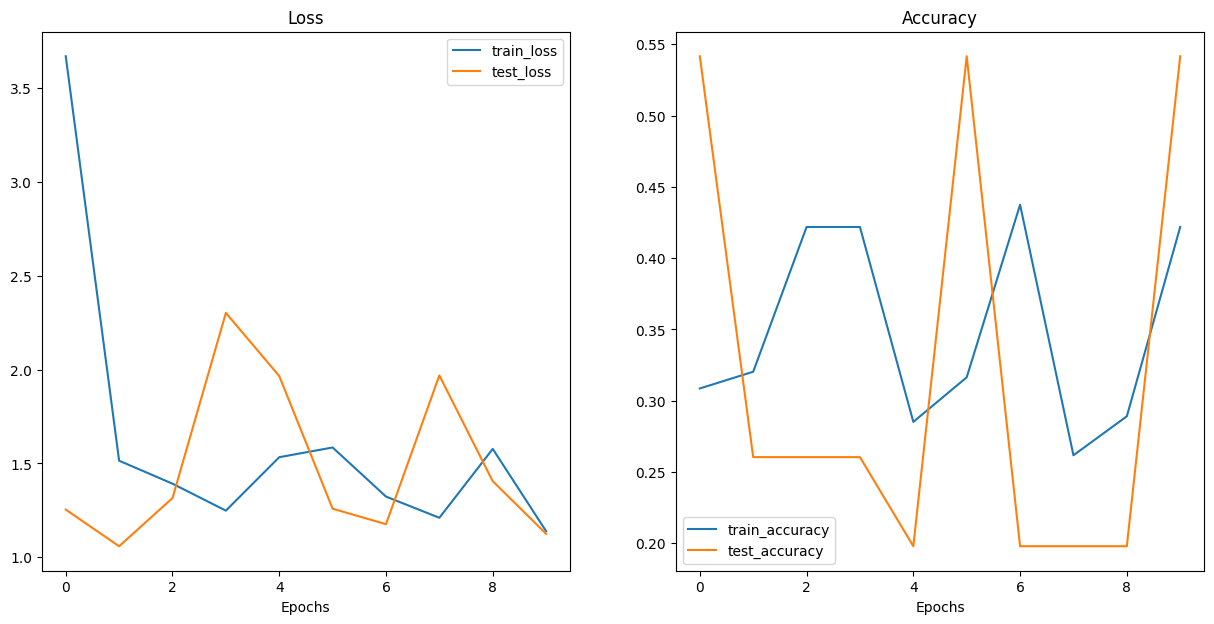

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained model ViT from `torchvision.models`

Generally, in deep learning, using a pretrained model from a large dataset can be good.
Transfer learning can achieve good results with less data.

### 10.1 **Why use a pretrained model?**
* sometimes data is limited
* Limited training resources
* Get better results faster

### 10.2 Prepare a pretrained ViT or use with FoodVision Mini
Turn it into a feature extractor

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Set up a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),  # batch_size, color_channels, height, width
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Number of parameters in pretrained ViT
num_params = 85,800,963
num_params

(85, 800, 963)

### 10.3 Preparing data for the pretrained ViT model
When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [ ]:
# Get automatic from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Set up dataloaders
from going_modular.going_modular import data_setup

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

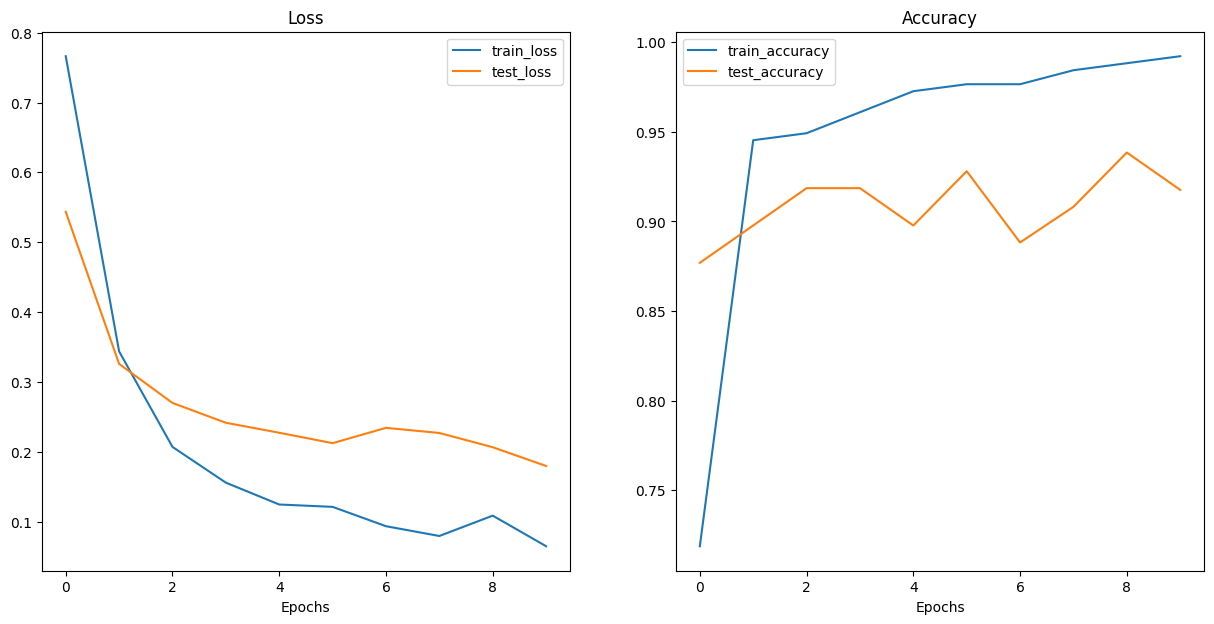

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save the best performing model

One model performs well.
Save the model to file and check the file size.

File size needs to be checked, because the deployment of the model to a website/mobile application can be limited due to size.

A smaller model might be requeired due to compute restrictions.

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*2014)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 166 MB


## 11. Predicting on a custom image

The ViT model performs well, however, the size of the model is larger.

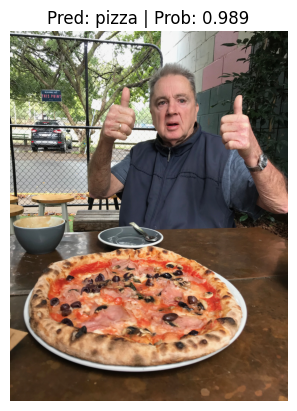

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)